In [1]:
import os
import networkx as nx
import csv 
import numpy as np
import random
import copy
import math 
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import pickle
import scipy

# Metrics

In [2]:
# the function cluster_proportions() computes the proportions of different communities in each cluster; 
# the community affiliation of a node is embedded in a graph attribute called 'color' ('b' for majority, 'r' for minority); for using the real data, embed as such.
def cluster_proportions(G, list_nodes_G, no_clusters, cluster_assignment):
    # sizes of clusters                                                                                                    
    unique, counts = np.unique(cluster_assignment, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    # cluster_proportion is a dictionary mapping from the clusters to the proportion of the majority nodes in each cluster 
    cluster_proportion = {}
    # cluster_majority is a dictionary mapping from the clusters to the number of the majority nodes in each cluster
    cluster_majority = {}
    # cluster_mminority is a dictionary mapping from the clusters to the number of the minority nodes in each cluster
    cluster_minority = {}
    for kk in range(no_clusters):
        cluster_proportion[kk] = 0
        cluster_majority[kk] = 0
        cluster_minority[kk] = 0

    for u in range(len(list_nodes_G)):
        if G.nodes[list_nodes_G[u]]['color'] == 'b':
            cluster_proportion[cluster_assignment[u]] += 1
            cluster_majority[cluster_assignment[u]] += 1
        else:
            cluster_minority[cluster_assignment[u]] += 1

    for kk in range(no_clusters):
        cluster_proportion[kk] /= cluster_sizes[kk]
    return cluster_sizes, cluster_proportion, cluster_majority, cluster_minority

# the function graph_communities() finds the ratio of majority and minority nodes in the graph
# the community affiliation of a node is embedded in a graph attribute called 'color' ('b' for majority, 'r' for minority); for using the real data, embed as such.
def graph_communities(G, list_nodes_G):
    maj_no = 0
    min_no = 0
    for u in range(len(list_nodes_G)):
        if G.nodes[list_nodes_G[u]]['color'] == 'b':
            maj_no += 1
        else:
            min_no += 1
    return maj_no, min_no

# interesting that this isn't equivalent to compute_fairness_linear, but it is very similar
def compute_fairness_linear_min_prop(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    # print(cluster_proportion)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    min_prop = min_no / (maj_no + min_no)
    w = (1 - min_prop) / min_prop
    for kk in range(no_clusters):
        fairness_clusters[kk] = abs(cluster_majority[kk] - (w * cluster_minority[kk]))
 
    fairness_overall = np.mean(list(fairness_clusters.values()))
    return fairness_clusters, fairness_overall

def compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = abs(cluster_minority[kk]- cluster_majority[kk]* (1 - maj_prop)/maj_prop)
 
    fairness_overall = np.mean(list(fairness_clusters.values()))
    return fairness_clusters, fairness_overall
    
# the function compute_avg_kdistance_cl() computes the average distance to the k-means center obtained from the kmeans algorithm for a specified cluster
# note: this is what k-means optimizes for 
def compute_avg_kdistance_cl_inertia(cluster_assignment, my_cluster, km_distances):
    sumdist = km_distances[np.where(cluster_assignment==my_cluster)][:,my_cluster].sum()
    return sumdist

# the function compute_avg_kdistance() computes the average distance of all clusters to their respective k-means centers obtained from the kmeans algorithm
# note: this is what k-means optimizes for 
def compute_avg_kdistance_inertia(cluster_assignment, no_clusters, km_distances):
    dist_clusters = {}
                                                                                                     
    for kkk in range(no_clusters):
        dist_clusters[kkk] = (km_distances[np.where(cluster_assignment==kkk)][:,kkk]).sum()
    sumdist = np.sum(list(dist_clusters.values()))
    return dist_clusters, sumdist

# Load in dataset

In [3]:
#Highschool dataset:
filename = 'Highschool-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
G_og = nx.read_edgelist('datasets/Friendship-network_data_2013.csv')

# get the largest connected component of the graph
gg = sorted(nx.connected_components(G_og),key=len,reverse=True)[0]
Gbig = G_og.subgraph(gg)
G_SBM = Gbig.copy()

# find the sensitive features (unanonymized gender) and place it in a dictionary
gender = {}

filename_read = 'datasets/metadata_2013.txt'
f = open(filename_read)
reader=csv.reader(f)

for row in reader:
    myrow = row[0].split('\t')
    gender[myrow[0]] = myrow[2]

list_init = list(G_SBM.nodes())
for u in list_init:
    if gender[u] == 'Unknown':
        G_SBM.remove_node(u)
        
# find the spectrum of the graph
list_nodes = list(G_SBM.nodes())

m = 0 
f = 0
d = {} 
for u in G_SBM.nodes():
    if gender[u] == 'M':
        d[u] = 'b'
        m += 1
    elif gender[u] == 'F':
        d[u] = 'r'
        f += 1
print('female: ', f)
print('male: ', m)

nx.set_node_attributes(G_SBM, d, name="color")

female:  76
male:  51


# Initial Spectral Clustering

In [15]:
# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 5 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k]]

U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)

In [16]:
[clf, avgf] = compute_fairness_linear(G_SBM, list_nodes,k,y)
print("Average unfairness: ", avgf)  

[clcost,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
print("Average cost: ", avgcost)

Average unfairness:  8.101960784313727
Average cost:  0.7056305852672413


In [17]:
def find_best_change(G, cluster_assignment, km_distances, no_clusters):
    list_nodes = list(G.nodes())
    [maj_no, min_no] = graph_communities(G_SBM, list_nodes)
    maj_prop = maj_no / (maj_no + min_no)
    w = (1 - maj_prop) / maj_prop
    
    changes_list = []
    for u in range(len(list_nodes)):
        for cluster in range(k):
            if cluster_assignment[u] != cluster:
                # calculate the change in cost - 2 parts, u joining new cluster, u leaving prev cluster
                dist_join = km_distances[u, cluster] # added cost from joining
                dist_leave = km_distances[u, cluster_assignment[u]] # subtracted cost from leaving
                cost = dist_join - dist_leave
                # print(cost)

                # calculate the change in fairness - 2 parts, u joining new cluster, u leaving prev cluster
                [_, _, cluster_majority, cluster_minority] = cluster_proportions(G_SBM, list_nodes, k, cluster_assignment)
                joined_cluster_maj = cluster_majority[cluster]
                joined_cluster_min = cluster_minority[cluster]

                left_cluster_maj = cluster_majority[cluster_assignment[u]]
                left_cluster_min = cluster_minority[cluster_assignment[u]]

                fair_join = abs(joined_cluster_min - (w * joined_cluster_maj)) # unfairness before
                fair_leave = abs(left_cluster_min - (w * left_cluster_maj)) # unfairness before

                if G_SBM.nodes[list_nodes[u]]['color'] == 'b':
                    joined_cluster_maj += 1
                    left_cluster_maj -= 1
                else:
                    joined_cluster_min += 1
                    left_cluster_min -= 1
                    
                # old unfairness minus new unfairness (fairness gain)
                fair_join -= abs(joined_cluster_min - (w * joined_cluster_maj)) 
                fair_leave -= abs(left_cluster_min - (w * left_cluster_maj))

                fairness = (fair_join + fair_leave) / no_clusters

                changes_list.append(((u, cluster), fairness, cost, fairness / cost))
                
    # search over changes with positive fairness gain and cost increase
    good_changes_list = [c for c in changes_list if c[1] > 0 and c[2] > 0]
    good_changes_list.sort(key=lambda a: a[3], reverse = True)
    if len(good_changes_list) > 0:
        best_change = good_changes_list[0]
        return best_change
    else:
        print("No more good changes")
        return 0

In [18]:
cluster_assignment = copy.deepcopy(y)
i = 0
f_vals = []
c_vals = []
while True:
    print(f"Iteration: {i}")
    i += 1
    # print metrics for current iteration
    [clf, avgf] = compute_fairness_linear(G_SBM, list_nodes, k, cluster_assignment)
    f_vals.append(avgf)
    # print("Average unfairness: ", avgf)
    [clcost,avgcost] = compute_avg_kdistance_inertia(cluster_assignment,k,X_dist)
    c_vals.append(avgcost)
    # print("Average cost: ", avgcost)
    
    # find best change
    best_change = find_best_change(G_SBM, cluster_assignment, X_dist, k)
    if best_change == 0:
        break
    best_change = best_change[0]
    
    # update clustering
    cluster_assignment[best_change[0]] = best_change[1]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
No more good changes


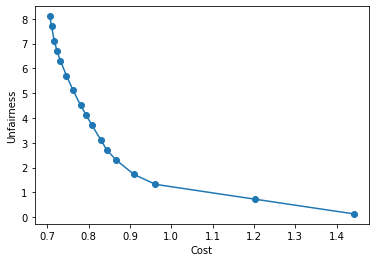

In [19]:
plt.scatter(c_vals, f_vals)
plt.plot(c_vals, f_vals)
plt.xlabel("Cost")
plt.ylabel("Unfairness");